# Demonstration of HAVOK Method

In [1]:
import os
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy import integrate
from scipy.integrate import odeint
from plot_utils import scatter_plot_3d

rcParams.update({'font.size': 14})
#plt.rcParams['figure.figsize'] = [12, 12]

In [2]:
# Directory for plot outputs
plot_dir = '../../plots'

## Simulate the Lorenz System

In [3]:
dt = 0.01
T = 50
t = np.arange(0,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28

def lorenz_odes(t, y, sigma, beta, rho):
    """The Lorenz system of ordinary differential equations.
    
    Returns:
        dydt (tuple): Derivative w.r.t. time
    """
    y1, y2, y3 = y
    return (sigma * (y2 - y1), y1 * (rho - y3) - y2, y1 * y2 - beta * y3)

# Test calculation
assert lorenz_odes(0, [1, 2, 3], sigma, beta, rho) == (10, 23, -6.0)

In [4]:
# Simulate using scipy.integrate.odeint method
# Produces same results as Matlab

# Initial condition
x0 = (-8, 8, 27)
fun = partial(lorenz_odes, sigma=sigma, beta=beta, rho=rho)
rtol = 10e-12
atol = 10e-12 * np.ones_like(x0)
x = odeint(fun, x0, t, tfirst=True, rtol=rtol, atol=atol)
assert x.shape == (5001, 3)

x[:5, :].round(3)

array([[-8.   ,  8.   , 27.   ],
       [-6.486,  7.803, 25.726],
       [-5.138,  7.563, 24.609],
       [-3.942,  7.313, 23.629],
       [-2.882,  7.078, 22.766]])

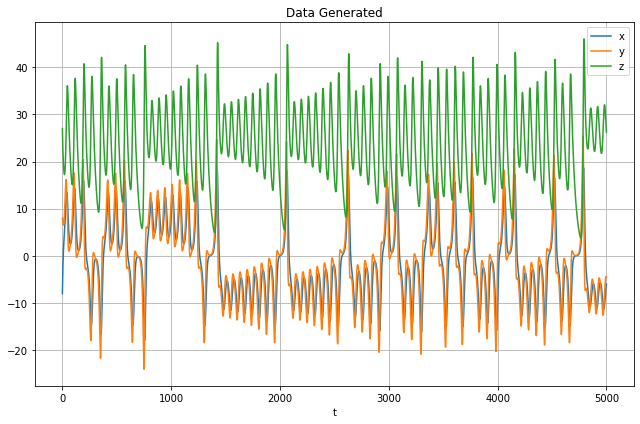

In [5]:
plt.figure(figsize=(9, 6))
plt.plot(x)
plt.title('Data Generated')
plt.xlabel('t')
plt.legend(labels=['x', 'y', 'z'])
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data.png')
plt.savefig(filepath)
plt.show()

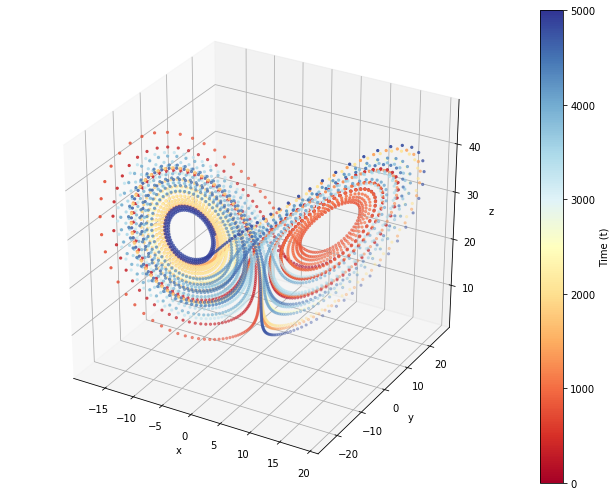

In [6]:
filepath = os.path.join(plot_dir, 'lorenz_data_3d.png')
scatter_plot_3d(x, filename=filepath)

## Take data for one measurement $x(t)$

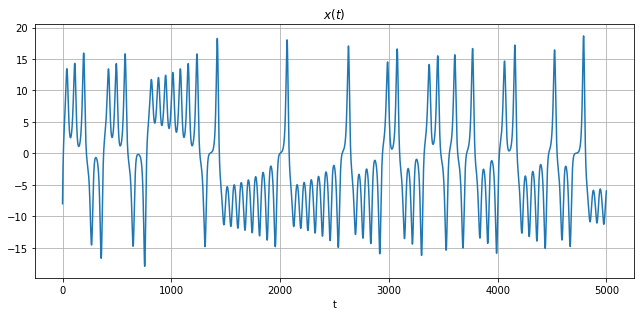

In [7]:
plt.figure(figsize=(9, 4.5))
plt.plot(x[:, 0])
plt.title('$x(t)$')
plt.xlabel('t')
plt.grid()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_x.png')
plt.savefig(filepath)
plt.show()

In [8]:
def hankel_matrix(x, n_shift):
    """Hankel matrix of eigen-time-delay coordinates.
    """
    assert n_shift > 1
    h = np.stack([np.roll(x, -i) for i in range(n_shift)])
    return h[:, :-n_shift+1]

h_test = hankel_matrix(np.array(range(5)), 3)
h_true = np.array([
    [0, 1, 2],
    [1, 2, 3],
    [2, 3, 4]
])
assert np.array_equal(h_test, h_true)

## Eigen-time delay coordinates

In [9]:
# Number of shifted rows
n_shift = 10
H = hankel_matrix(x[:, 0], n_shift)
H.shape

(10, 4992)

In [10]:
H[:, :5].round(3)

array([[-8.   , -6.486, -5.138, -3.942, -2.882],
       [-6.486, -5.138, -3.942, -2.882, -1.944],
       [-5.138, -3.942, -2.882, -1.944, -1.113],
       [-3.942, -2.882, -1.944, -1.113, -0.375],
       [-2.882, -1.944, -1.113, -0.375,  0.284],
       [-1.944, -1.113, -0.375,  0.284,  0.877],
       [-1.113, -0.375,  0.284,  0.877,  1.414],
       [-0.375,  0.284,  0.877,  1.414,  1.905],
       [ 0.284,  0.877,  1.414,  1.905,  2.36 ],
       [ 0.877,  1.414,  1.905,  2.36 ,  2.787]])

In [11]:
# Compute SVD
U, S, VT = np.linalg.svd(H, full_matrices=False)
V = VT.T

U.shape, S.shape, V.shape

((10, 10), (10,), (4992, 10))

In [12]:
## Compute Derivatives (4th Order Central Difference)
dV = (1/(12*dt)) * (-V[4:,:] + 8*V[3:-1,:] - 8*V[1:-3,:] + V[:-4,:])

# trim first and last two that are lost in derivative
V = V[2:-2]
V.shape

(4988, 10)

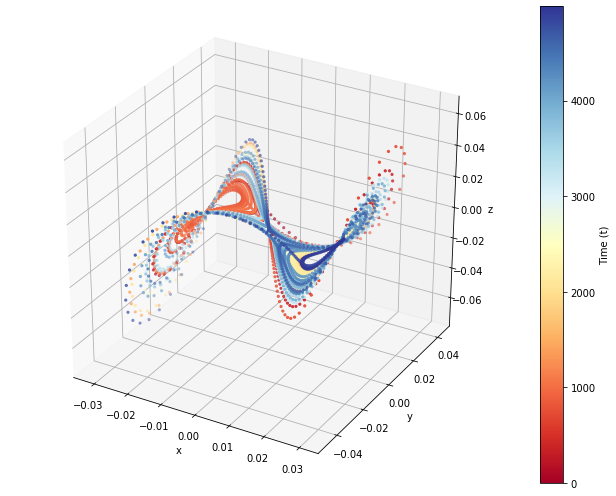

In [13]:
# First 3 columns of V are an embedded attractor of the Lorenz system
filepath = os.path.join(plot_dir, 'lorenz_embedded.png')
scatter_plot_3d(V[:,:3], filename=filepath)

In [14]:
V[:, 9].shape

(4988,)

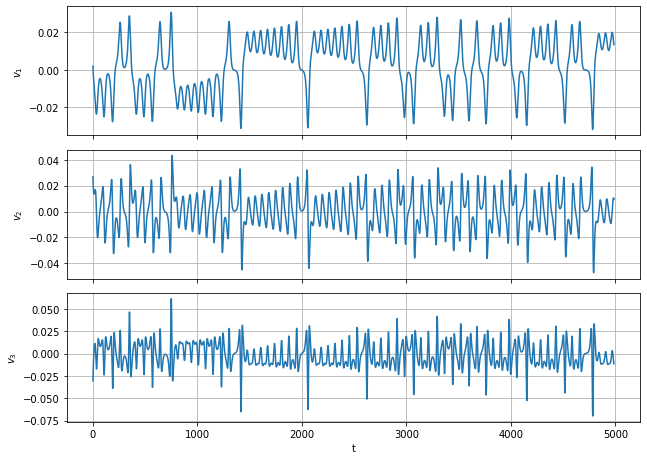

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(9, 6.5), sharex=True)
for i, row in enumerate([0, 1, 2]):
    label = "$v_{%d}$" % (row + 1)
    axes[i].plot(V[:, row], label=label)
    axes[i].set_ylabel(label)
    axes[i].grid()

axes[-1].set_xlabel('t')
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_v.png')
plt.savefig(filepath)
plt.show()

In [18]:
# Choose rank of HAVOK model
r = 10

## Analyse Forcing Values

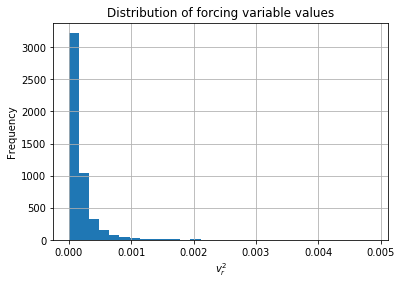

In [19]:
forcing_values = V[:, r-1]**2

plt.hist(V[:, row]**2, bins=30)
plt.title('Distribution of forcing variable values')
plt.xlabel('$v_r^2$')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [20]:
is_forcing = forcing_values > 0.00005  # Choose threshold
round(sum(is_forcing) / len(is_forcing), 4)

0.3326

In [21]:
plot_data = {
    "v_1": V[:, 0],
    "v_r^2": V[:, r-1]**2
}
plot_data = pd.DataFrame(plot_data, index=t[7:-6])

plot_data["v_1 not forcing"] = plot_data.loc[~is_forcing, "v_1"]
plot_data["v_1 forcing"] = plot_data.loc[is_forcing, "v_1"]
plot_data["v_r^2 not forcing"] = plot_data.loc[~is_forcing, "v_r^2"]
plot_data["v_r^2 forcing"] = plot_data.loc[is_forcing, "v_r^2"]

plot_data.head()

,v_1,v_r^2,v_1 not forcing,v_1 forcing,v_r^2 not forcing,v_r^2 forcing
0.07,0.001962,0.000011,0.001962,NaN,0.000011,NaN
0.08,0.000611,0.000297,NaN,0.000611,NaN,0.000297
0.09,-0.000602,0.000970,NaN,-0.000602,NaN,0.000970
0.10,-0.001696,0.001565,NaN,-0.001696,NaN,0.001565
0.11,-0.002692,0.001916,NaN,-0.002692,NaN,0.001916


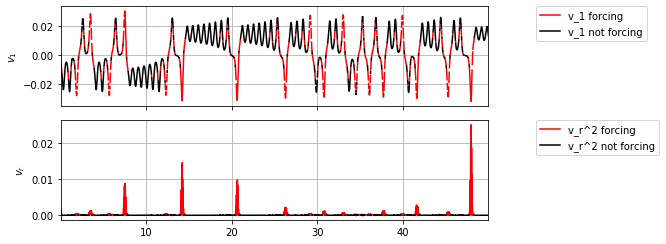

In [33]:
fig, axes = plt.subplots(2, 1, figsize=(9.5, 3.5), sharex=True)

plot_data['v_1 forcing'].plot(ax=axes[0], style='r-')
plot_data['v_1 not forcing'].plot(ax=axes[0], style='k-')
axes[0].set_ylabel('$v_1$')
axes[0].grid()
axes[0].legend(bbox_to_anchor=(1.1, 1.05))

plot_data['v_r^2 forcing'].plot(ax=axes[1], style='r-')
plot_data['v_r^2 not forcing'].plot(ax=axes[1], style='k-')
axes[1].set_ylabel('$v_r$')
axes[1].grid()
axes[1].legend(bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_data_forcing.png')
plt.savefig(filepath)
plt.show()

## Build HAVOK Regression Model on Time Delay Coordinates

In [23]:
xi = np.linalg.lstsq(V, dV, rcond=None)[0]
xi.shape

(10, 10)

In [24]:
A = xi[:(r-1), :(r-1)].T
B = xi[-1, :(r-1)].T

A.shape, B.shape

((9, 9), (9,))

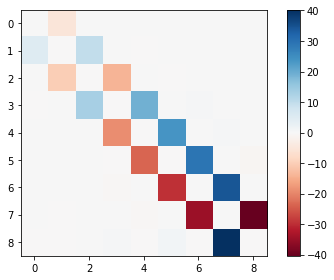

In [25]:
plt.imshow(A, cmap='RdBu')
plt.colorbar()
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model.pdf')
plt.savefig(filepath)
plt.show()

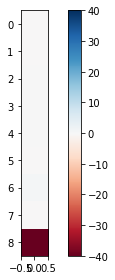

In [26]:
plt.imshow(B.reshape(-1,1), cmap='RdBu')
plt.colorbar()
plt.clim(-40, 40)
plt.tight_layout()
filepath = os.path.join(plot_dir, 'lorenz_reg_model_b.png')
plt.savefig(filepath)
plt.show()

## Make Predictions with the Model

In [29]:
v0 = V[0, :9]
u0 = V[0, 9]

def dVdt(v, u):
    return A.dot(v) + B.dot(u)

dVdt(v0, u0)

array([-0.14277931, -0.30623686,  0.51637919,  0.48274792, -0.3581351 ,
       -0.03279252,  0.49462095, -1.09949867, -1.68657078])